# FP-Growth

### Hecho con ❤ por:
### Acosta Imandt Daniel
### Callejas Hernández Edgar
### Garduño Martínez Eduardo

## Introducción


Es de sumo interés para tiendas de autoservicio poder saber cuales son los productos que se venden más juntos, con ayuda de las reglas de asociación, esto se hace con la finalidad de poder poner estos productos en lugares cercanos o crear promociones de estos y aumentar las ventas de los usuarios.

In [1]:
#Cargamos libererías
!pip install networkx
!pip install pydot==1.4.2
import pandas as pd
from itertools import combinations
from itertools import permutations 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib.pyplot import figure



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 82.4 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Exploración de los datos

In [2]:
depa=pd.read_csv('departments.csv')
print(depa.shape)
depa.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [3]:
pas=pd.read_csv('aisles.csv')
print(pas.shape)
pas.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
product = pd.read_csv('products.csv')
def product_name(idp):
    return product[product['product_id']==idp]['product_name'].values.item()

print(product.shape)
product.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
data = pd.read_csv('orders_file1.csv')
data = data[['order_id','product_id']]
data = data.groupby(['order_id'])['product_id'].apply(list).reset_index(name='Description')
data.head(5)

,order_id,Description
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"


# Algoritmo

## Paso 1. Calcular las frecuencias

In [6]:
#Contamos el total de palabras y definimos el soporte minimo
total_trans = data['order_id'].nunique()
minSup = 0.075
minSup2=0.09

In [7]:
data_ = pd.read_csv('orders_file1.csv')
#Contamos el número de transacciones que tuvo un producto
data1 = data_.groupby(['product_id'])['order_id'].count().reset_index(name='Description')
data1.head()


,product_id,Description
0,1,103
1,2,6
2,3,8
3,4,25
4,8,5


In [8]:
#Pasamos a un diccionario el id del producto y el número de transacciones en las que aparece
frec = {}
for j in range(data1.shape[0]):
    frec[data1.iloc[j,0]] = data1.iloc[j,1]

#frec

In [9]:
frec_prods = pd.DataFrame({'id':frec.keys(),'frecuencia':frec.values()})
merged_left = pd.merge(left=product, right=pas, how='left', left_on='aisle_id', right_on='aisle_id')
merged_left = pd.merge(left=merged_left, right=depa, how='left', left_on='department_id', right_on='department_id')
merged_left = pd.merge(left=merged_left, right=frec_prods, how='left', left_on='product_id', right_on='id')
merged_left=merged_left[['id','product_name','aisle','department', 'frecuencia']]
merged_left.head()

,id,product_name,aisle,department,frecuencia
0,1.0,Chocolate Sandwich Cookies,cookies cakes,snacks,103.0
1,2.0,All-Seasons Salt,spices seasonings,pantry,6.0
2,3.0,Robust Golden Unsweetened Oolong Tea,tea,beverages,8.0
3,4.0,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen,25.0
4,NaN,Green Chile Anytime Sauce,marinades meat preparation,pantry,NaN


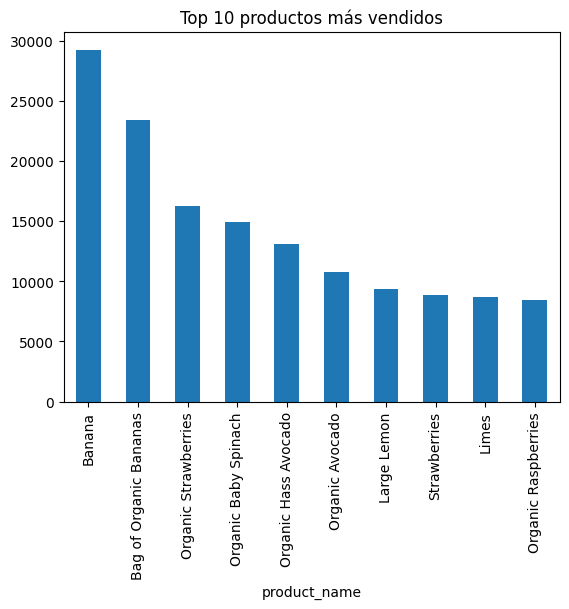

In [10]:
merged_left.groupby('product_name')['frecuencia'].sum().sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Top 10 productos más vendidos')
plt.show()

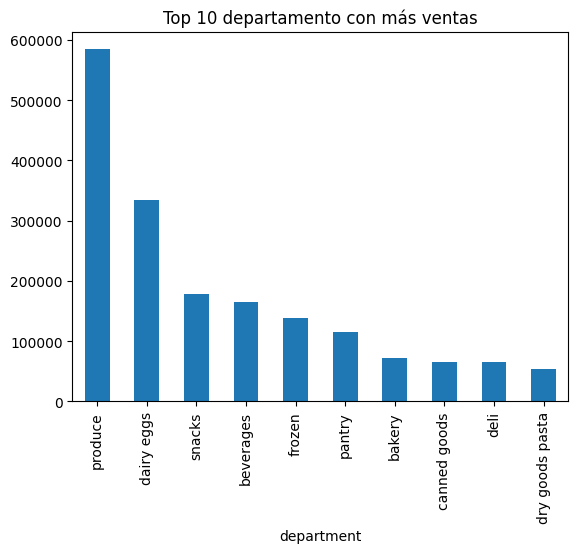

In [11]:
merged_left.groupby('department')['frecuencia'].sum().sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Top 10 departamento con más ventas')
plt.show()

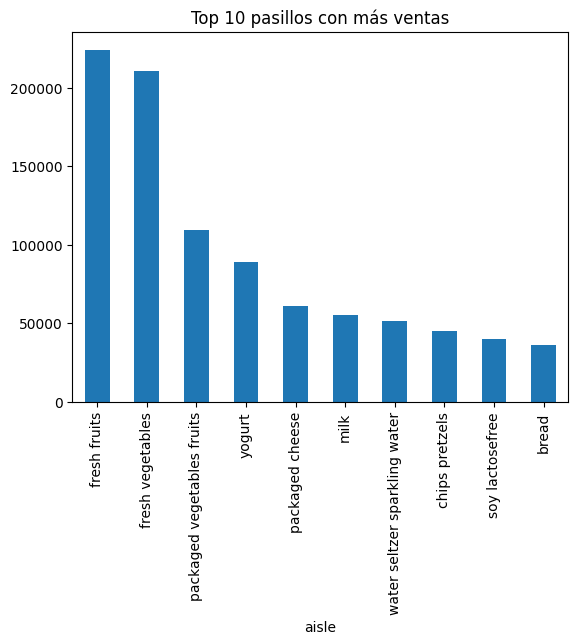

In [12]:
merged_left.groupby('aisle')['frecuencia'].sum().sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Top 10 pasillos con más ventas')
plt.show()

In [13]:
#Ordenamos por el nùmero de apariciones
frec1=sorted(frec.items(), key=lambda x:x[1],reverse=True)
frec1[0]

(24852, 29255)

## Paso 2.  Re-escribir los TIDS

In [14]:
#Ordenamos  los productos por transacciones
data['Description'] = data['Description'].apply(lambda x: sorted(x,key = lambda i:frec[i], reverse=True))

In [15]:
# Filtramos nuestros datos por el sporte minimo
desc_filtrada = []
desc_filtrada2 = []
for t in data.itertuples():
    #print(t[2])
    desc_filtrada.append(list(filter(lambda item: (frec[item]/total_trans >= minSup), t[2])))
    desc_filtrada2.append(list(filter(lambda item: (frec[item]/total_trans >= minSup2), t[2])))
    
desc_filtrada = [x for x in desc_filtrada if x != []]
desc_filtrada2 = [x for x in desc_filtrada2 if x != []]

desc_filtrada_nombres = []
for t in desc_filtrada:
    desc_filtrada_nombres.append(list(map(product_name,t)))

desc_filtrada_nombres2 = []
for t in desc_filtrada2:
    desc_filtrada_nombres2.append(list(map(product_name,t)))

desc_filtrada_nombres

KeyboardInterrupt: 

In [ ]:
desc_filtrada2 = []
for t in data.itertuples():
    #print(t[2])
    
    desc_filtrada2.append(list(filter(lambda item: (frec[item]/total_trans >= minSup2), t[2])))
    

desc_filtrada2 = [x for x in desc_filtrada2 if x != []]


desc_filtrada_nombres2 = []
for t in desc_filtrada2:
    desc_filtrada_nombres2.append(list(map(product_name,t)))

desc_filtrada_nombres2

In [16]:

rutas = {}
rutas_ = {}
for j in desc_filtrada_nombres:
    for v in j:
        rutas[v] = []
        rutas_[v] = []

for j in desc_filtrada_nombres:
    for i in range(len(j)-1,0,-1):
        if j[:i] in rutas[j[i]]:
            indice = rutas[j[i]].index(j[:i])
            rutas_[j[i]][indice] += 1
        else:
            rutas[j[i]].append(j[:i])
            rutas_[j[i]].append(1)
rutas_

{'Organic Baby Spinach': [2595, 1111, 617, 2435, 629, 7],
 'Bag of Organic Bananas': [72],
 'Banana': [],
 'Organic Strawberries': [3507, 3789, 10]}

In [ ]:
rutas2 = {}
rutas_2 = {}
for j in desc_filtrada_nombres2:
    for v in j:
        rutas2[v] = []
        rutas_2[v] = []

for j in desc_filtrada_nombres2:
    for i in range(len(j)-1,0,-1):
        if j[:i] in rutas2[j[i]]:
            indice2 = rutas2[j[i]].index(j[:i])
            rutas_2[j[i]][indice2] += 1
        else:
            rutas2[j[i]].append(j[:i])
            rutas_2[j[i]].append(1)
rutas_2

In [17]:
rutas

{'Organic Baby Spinach': [['Banana'],
  ['Organic Strawberries'],
  ['Banana', 'Organic Strawberries'],
  ['Bag of Organic Bananas'],
  ['Bag of Organic Bananas', 'Organic Strawberries'],
  ['Banana', 'Bag of Organic Bananas']],
 'Bag of Organic Bananas': [['Banana']],
 'Banana': [],
 'Organic Strawberries': [['Banana'],
  ['Bag of Organic Bananas'],
  ['Banana', 'Bag of Organic Bananas']]}

In [18]:
def devolver_pref(a,b):
    prefijos = []
    for j in range(len(a)-1,-1,-1):
        if a[:j+1] == b[:len(a[:j+1])]:
            prefijos.append(a[:j+1])
            break
    if len(prefijos) == 0:
        return False
    else:
        return prefijos

##  Paso 3. Construimos el FP-TREE

In [19]:
def get_correct_name(nodo):
    nodo = nodo.replace('[','')
    nodo = nodo.replace(']','')
    nodo = nodo.split(',')
    return nodo[-1]

def format_name(te):
    te = te.replace("'",'')
    te = te.replace(' ', '\n')
    return te

def es_prefijo(ruta,p):
    return p == ruta[:len(p)]
#Creamos el arbol
g = nx.DiGraph()
for j in desc_filtrada_nombres:
    for k in range(len(j)):
        if k == 0:
            if g.has_edge('Null',str(j[:k+1])):
                g['Null'][str(j[:k+1])]['count'] += 1
            else:
                g.add_edge('Null',str(j[:k+1]),count=1)
        else:
            if g.has_edge(str(j[:k]),str(j[:k+1])):
                g[str(j[:k])][str(j[:k+1])]['count'] += 1
            else:
                g.add_edge(str(j[:k]),str(j[:k+1]),count=1)

correct_names = dict()
for n in g.nodes:
    correct_names[n] = format_name(get_correct_name(n))


#Creamos el arbol2
g2 = nx.DiGraph()
for j in desc_filtrada_nombres2:
    for k in range(len(j)):
        if k == 0:
            if g2.has_edge('Null',str(j[:k+1])):
                g2['Null'][str(j[:k+1])]['count'] += 1
            else:
                g2.add_edge('Null',str(j[:k+1]),count=1)
        else:
            if g2.has_edge(str(j[:k]),str(j[:k+1])):
                g2[str(j[:k])][str(j[:k+1])]['count'] += 1
            else:
                g2.add_edge(str(j[:k]),str(j[:k+1]),count=1)

correct_names2 = dict()
for n in g2.nodes:
    correct_names2[n] = format_name(get_correct_name(n))

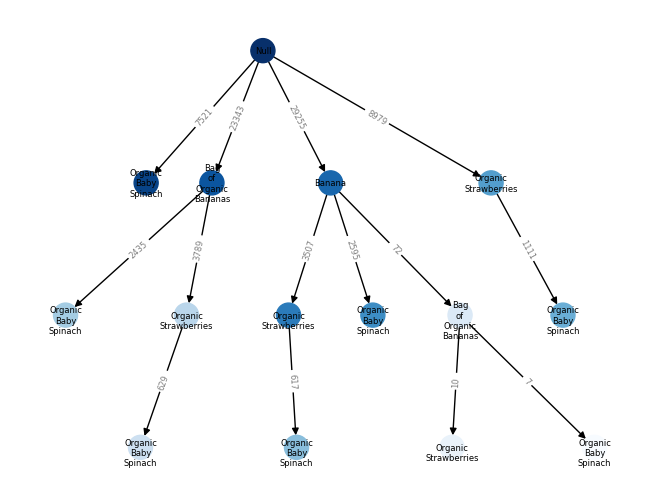

In [20]:

#figure(figsize=(15, 10), dpi=80)
pos = nx.spring_layout(g)
pos1 = graphviz_layout(g, prog="dot")
labels = nx.get_edge_attributes(g,'count')
nx.draw(g,with_labels=True,pos=pos1,font_size=6, labels=correct_names,cmap=plt.cm.Blues,node_color=range(len(g),0,-1))
nx.draw_networkx_edge_labels(g,pos=pos1,alpha=0.5,edge_labels=labels,
                            font_family="sans-serif", font_size=6)
plt.show()

In [ ]:
#figure(figsize=(15, 10), dpi=80)
pos = nx.spring_layout(g2)
pos1 = graphviz_layout(g2, prog="dot")
labels = nx.get_edge_attributes(g2,'count')
nx.draw(g2,with_labels=True,pos=pos1,font_size=6, labels=correct_names,cmap=plt.cm.Blues,node_color=range(len(g),0,-1))
nx.draw_networkx_edge_labels(g2,pos=pos1,alpha=0.5,edge_labels=labels,
                            font_family="sans-serif", font_size=6)
plt.show()

## Paso 4. Patrones base

In [23]:

pat_cond = dict()

for pb in rutas.keys():
    prefijos = []
    for r in rutas[pb]:
        for vr in range(len(r),0,-1):
            if r[:vr] in prefijos:
                pass
            else:
                prefijos.append(r[:vr])

    pre_dict = dict()

    #inicializamos los valores
    for p in prefijos:
        pre_dict[tuple(p)] = 0

    for p in prefijos:
            for ruta in rutas[pb]:
                if es_prefijo(ruta,p):
                    indice = rutas[pb].index(ruta)
                    pre_dict[tuple(p)] += rutas_[pb][indice]

    pat_cond[pb] = pre_dict

pat_cond

{'Organic Baby Spinach': {('Banana',): 3219,
  ('Organic Strawberries',): 1111,
  ('Banana', 'Organic Strawberries'): 617,
  ('Bag of Organic Bananas',): 3064,
  ('Bag of Organic Bananas', 'Organic Strawberries'): 629,
  ('Banana', 'Bag of Organic Bananas'): 7},
 'Bag of Organic Bananas': {('Banana',): 72},
 'Banana': {},
 'Organic Strawberries': {('Banana',): 3517,
  ('Bag of Organic Bananas',): 3789,
  ('Banana', 'Bag of Organic Bananas'): 10}}

In [ ]:
pat_cond2 = dict()

for pb in rutas2.keys():
    prefijos2 = []
    for r in rutas2[pb]:
        for vr in range(len(r),0,-1):
            if r[:vr] in prefijos2:
                pass
            else:
                prefijos2.append(r[:vr])

    pre_dict2 = dict()

    #inicializamos los valores
    for p in prefijos2:
        pre_dict2[tuple(p)] = 0

    for p in prefijos2:
            for ruta in rutas2[pb]:
                if es_prefijo(ruta2,p):
                    indice2 = rutas2[pb].index(ruta)
                    pre_dict2[tuple(p)] += rutas_2[pb][indice2]

    pat_cond2[pb] = pre_dict2

pat_cond2

In [24]:
patron_grande = {}
for j in pat_cond.keys():
    patron_grande[j] = [None,0]

for j in pat_cond.keys():
    for k in pat_cond[j].keys():

        if patron_grande[j][0] == None:
            patron_grande[j][0] = k[0]
            patron_grande[j][1] = pat_cond[j][k]
        
        elif patron_grande[j][0] != None and patron_grande[j][1] < pat_cond[j][k]:
            patron_grande[j][0] = k[0]
            patron_grande[j][1] = pat_cond[j][k]

patron_grande

{'Organic Baby Spinach': ['Banana', 3219],
 'Bag of Organic Bananas': ['Banana', 72],
 'Banana': [None, 0],
 'Organic Strawberries': ['Bag of Organic Bananas', 3789]}

##  Paso 5. Patrones Condicionales

In [25]:
rutas

{'Organic Baby Spinach': [['Banana'],
  ['Organic Strawberries'],
  ['Banana', 'Organic Strawberries'],
  ['Bag of Organic Bananas'],
  ['Bag of Organic Bananas', 'Organic Strawberries'],
  ['Banana', 'Bag of Organic Bananas']],
 'Bag of Organic Bananas': [['Banana']],
 'Banana': [],
 'Organic Strawberries': [['Banana'],
  ['Bag of Organic Bananas'],
  ['Banana', 'Bag of Organic Bananas']]}

In [26]:
rutas_

{'Organic Baby Spinach': [2595, 1111, 617, 2435, 629, 7],
 'Bag of Organic Bananas': [72],
 'Banana': [],
 'Organic Strawberries': [3507, 3789, 10]}

In [27]:
patrones_cond = {}
for key,values in rutas.items():
    patrones_cond[key] = []

for key,values in rutas.items():
    if len(values) == 1:
        patrones_cond[key] = values

    else:
        for j in range(1,len(values)):
            if devolver_pref(values[0],values[j]) == False:
                patrones_cond[key] = []
                break
            else:
                patrones_cond[key].append(devolver_pref(values[0],values[j]))

for key,values in patrones_cond.items():
    x_ = []
    for j in values:
        if len(x_) == 0 and len(j) != 0:
            x_ = j
        elif len(j) < len(x_):
            x_ = j
    if len(x_) == 0 or len(x_) == 1:
        patrones_cond[key] = x_
    else:
        patrones_cond[key] = x_[0]

patrones_cond

{'Organic Baby Spinach': [],
 'Bag of Organic Bananas': ['Banana'],
 'Banana': [],
 'Organic Strawberries': []}

# Paso 6. Métricas y Reglas de asociación

### Soporte

Esta medida nos dice que tan frecuente es el item o items s entre todas las transacciones.

Esta medida es muy buena para ayudarnos a jenerar más ánalisis ya que podemos estar interesados solo en items que aparezcan cierto total de veces.

$$sup(x)=\frac{\#\text{transacciones con }x}{\# \text{transacciones totales}}$$

In [33]:
tottrans=data.shape[0]
def sup(x):
    for j in x:
        cont=0
        for l in desc_filtrada_nombres:
            esta_list = [True if e in l else False for e in x ]
            if all(esta_list): cont+=1


    return(cont/tottrans)

### Confianza

 La probabilidad de que ocurra el consecuente($y$) dado el antecedente($x$)

$$confianza(x,y)=\frac{sup(x \cup y)}{sup(x)}$$

In [35]:
def conf(x,xy):
    supxy=sup(xy)
    supx=sup(x)
    return(supxy/supx)

### Lift


$lift < 1 \implies$ Que dado el antecedente no  aumentan las chances de que ocurra el consecuente
$lift \geq 1 \implies$ Que dado el antecedente  aumentan las chances de que ocurra el consecuente

$$lift= \frac{soporte(union(X,Y))}{soporte(X)*soporte(Y)}$$

In [37]:
def lift(x,y,xy):
    supxy=sup(xy)
    supx=sup(x)
    supy=sup(x)
    return(supxy/supx*supy)

### Todas juntas :)

In [84]:
perm = permutations(rutas.keys(), 2) 
metricas=pd.DataFrame(perm)
metricas.set_axis(['X', 'Y'], axis='columns', inplace=True)
metricas['Soporte de X'] = metricas.apply(lambda x: sup(x[['X']]), axis=1)
metricas['Confianza'] = metricas.apply(lambda x: conf(x[['X']], x[['X','Y']]), axis=1)
metricas['lift'] = metricas.apply(lambda x: lift(x[['X']],x[['Y']], x[['X','Y']]), axis=1)

metricas

,X,Y,Confianza,lift,Soporte de X
0,Organic Baby Spinach,Bag of Organic Bananas,0.205900,0.015503,0.075296
1,Organic Baby Spinach,Banana,0.215823,0.016251,0.075296
2,Organic Baby Spinach,Organic Strawberries,0.158029,0.011899,0.075296
3,Bag of Organic Bananas,Organic Baby Spinach,0.131155,0.015503,0.118206
4,Bag of Organic Bananas,Banana,0.003075,0.000363,0.118206
5,Bag of Organic Bananas,Organic Strawberries,0.162246,0.019179,0.118206
6,Banana,Organic Baby Spinach,0.110032,0.016251,0.147688
7,Banana,Bag of Organic Bananas,0.002461,0.000363,0.147688
8,Banana,Organic Strawberries,0.120219,0.017755,0.147688
9,Organic Strawberries,Organic Baby Spinach,0.144734,0.011899,0.082212


## Conclusiones

Como ya se ha hablado los modelos de mercado canasata son de gran importancia para los mercados y centros departmanetales ya que permiten la minería de elementos frecuentes y así poder encontrar tendencias o patrones entre estos datos para poder tomar mejores decisiones futuras.
Pero ahora hay un problema ya que es una cantidad de datos increiblemente grande tomar todas las transacciones y todos los prodictos comparandolos entre si,por lo que hay una increible necesidad de encontrar formas de analizaar estos patrones de la forma más eficientemente posible, por lo que se suele utilizar los árboles de enumeración para estas tareas en específico se utlizo el algoritmo de FP-Growth, el cual se deriva del Apriori, este se utilizo ya que optimiza el espacio en memoria y es más rapido que otros.

Despues de hacer todo el analisis notamos que hay elementos bastante frecuentes como las bananas ( A las personas les suelen gustar las 🍌) y aunque parece que si hay una tendencia de dado $x$ la gente compra $y$, no se puede asegurar nada, ya que los valores del $lift$ son menores a 1

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=80ec0f28-1f0b-407e-ab64-4296834938a0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>